In [ ]:
'''Read technological tree

This module contains several useful functions to retrieve information from the tech tree:

* `ohol_tech.recipe(id)`: Pretty-prints the recipe to generate an object
* `ohol_tech.plot_tree(id, depth=None)`: Plots steps in the tech tree leading up to a id, up to a certain depth

'''

In [7]:
import pymongo
import pandas as pd
from IPython.core.display import display, HTML
from itertools import groupby
import matplotlib.pyplot as plt
import networkx as nx
import random
from utils import int_extract
from networkx.drawing.nx_pydot import graphviz_layout


# from pathlib import Path
# from utils import opj

# key_dir = (Path(__file__).parent / "6_database/").resolve()
# keyfile = opj(key_dir, 'credentials.key')

In [2]:
## Connect to database
def connect():
     #Connection string
    keyfile = '6_database/credentials.key' # Replace after conversion
    creds = open(keyfile, "r").read().splitlines()
    myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
    ohol = myclient.ohol
    
    return ohol

## Load tech tree
def load_tech_tree():
    
    ohol = connect()
    tech_df = pd.DataFrame(list(ohol.tech_tree.find()))
    tech_df = tech_df[['id', 'depth', 'recipe']]
    tech_df = tech_df.set_index('id')

    tech_tree = tech_df.to_dict('index')
    return tech_tree
tech_tree = load_tech_tree()

## Load objects from database
def load_objects():
    
    ohol = connect()
    obj_df = pd.DataFrame(list(ohol.objects.find()))
    obj_df = obj_df[['id', 'name']]

    return obj_df
objects = load_objects()

## Load transitions
def load_transitions():
    
    ohol = connect()
    trans_df = pd.DataFrame(list(ohol.expanded_transitions.find()))
    trans_df = trans_df[['origActor', 'origTarget', 'newActor', 'newTarget']]
    
    return trans_df

transitions = load_transitions()

## Object depth
def depth(obj):
    return tech_tree[obj]['depth']

In [3]:
def obj_name(obj):
    
    if obj < 1:
        return 'empty'
    else:
        return objects[objects.id == obj].name.values[0]

In [4]:
## Get recipe
def search_recipe(obj, recipeList=None):
    '''
    Returns full recipe by searching recursively through the tech tree
    '''
    # If recipe is empty, start a new list
    if recipeList is None:
        recipeList = []
    
    # Search recursively through object parents
    prev_step = tech_tree[obj]['recipe']
    if prev_step is not None:
        recipeList.append(prev_step)
        parents = [prev_step['origActor'], prev_step['origTarget']]
        for p in parents:
            search_recipe(p, recipeList)
    return recipeList

def get_recipe(obj):
    '''
    Cleans up the outputs of `search_recipe` by removing duplicate transitions
    and sorting transitions from simplest to most complex
    '''
    # Remove duplicate steps
    raw_recipe = search_recipe(obj)
    trimmed_recipe = list(map(dict, set(tuple(sorted(d.items())) for d in raw_recipe)))
    
    # Order transitions from simplest to most complex
    depths = [max(depth(e['newActor']), depth(e['newTarget'])) for e in trimmed_recipe] 
    ordered_recipe = list(zip(depths, trimmed_recipe))
    ordered_recipe.sort(key=lambda l:l[0])
    
    # Returns two lists: depths, recipe steps
    return list(zip(*ordered_recipe)) 

In [5]:
def get_ingredients(obj_recipe):
    ingredients = [(step['origActor'], step['origTarget']) for step in obj_recipe]
    ingredients_unwrapped = [i for step in ingredients for i in step if i > 1]
    return set(ingredients_unwrapped)

In [6]:
## Render single transition in HTML
def embed(s): return display(HTML(s))
def display_transition(recipe_step):
    '''
    Displays transitions in pretty, HTML-formatted text
    '''
    # Get item names
    names = {k:obj_name(v) for k,v in recipe_step.items()}
    
    # Generate HTML tags
    tag = '<mark style="background-color: %s;">%s</mark>'
    actor_color = '#91d8f2'
    target_color = '#ffbf6b'
    out = '(%s,%s) &#x2192; (%s,%s)' % (tag % (actor_color, names['origActor']),
                                        tag % (target_color, names['origTarget']),
                                        tag % (actor_color, names['newActor']),
                                        tag % (target_color, names['newTarget']))
    
    embed(out)

## Render all transitions in a recipe
def display_recipe(obj):
    
    depths,recipe = get_recipe(obj)
    recipe_tuple = list(zip(depths,recipe))
    
    for depth,group in groupby(recipe_tuple, key=lambda l:l[0]):
        embed('<h2>Step %i</h2>' % depth)
        for step in group:
            display_transition(step[1])

In [8]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

Natural
Natural
Natural
Natural
Natural


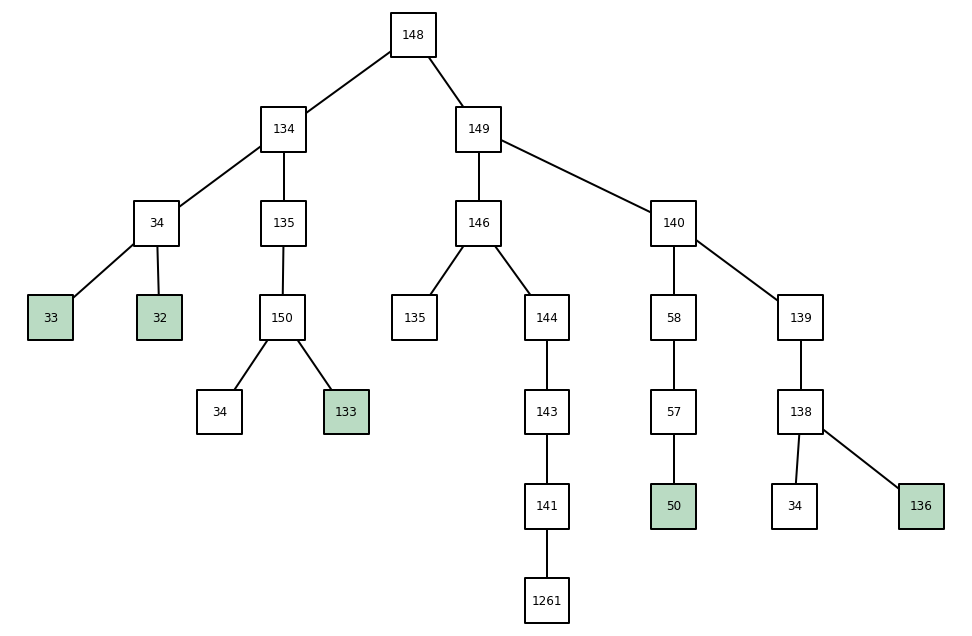

In [34]:
obj = 148

# Get recipe and object depths
depths,recipe=get_recipe(obj)
max_depth = max(depths)

# Sort recipe from the end product down
recipe_df = pd.DataFrame(recipe)
recipe_df['depth'] = depths
recipe_df = recipe_df.sort_values('depth', ascending=False)

# Helper functions: Identify next transition down
def is_product(p): return (recipe_df.newActor == p) | (recipe_df.newTarget == p)
def is_ingredient(p): return (recipe_df.origActor == p) | (recipe_df.origTarget == p)

# Build graph iteratively
G=nx.Graph()
products = [str(obj)]
expanded = []

depth_counter = max_depth

while depth_counter > 0:
    next_products = []
    
    for p in products:
        
        obj_id = int_extract('^[0-9]+', p)
        obj_depth = tech_tree[obj_id]['depth']
        
        if (obj_id not in expanded):
            # Search for parents
            parent_search = recipe_df[is_product(obj_id) & ~is_ingredient(obj_id)]
            if not parent_search.empty:
                parent_row = parent_search.iloc[0]
                parents = [parent_row['origActor'], parent_row['origTarget']]
                parents = ['%i_%i' % (parent, obj_id) for parent in parents if parent > 0] # remove 0, -1, -2

                # Add to graph
                G.add_edges_from([(p, parent) for parent in parents])
                expanded.append(obj_id)

                # Search through parents next            
                next_products += parents
            else:
                print('Natural')
                G.nodes[p]['color'] = '#badbc3'
    
    # Start next iteration
    products = next_products
    depth_counter -= 1

# Dynamically resize the graph
pos = graphviz_layout(G, prog="dot")
pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])

w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/50
h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/50

#w = max(w, 7.5)
#h = max(h, 7.5)

# Plot graph
node_labels = {n: int_extract('^[0-9]+', n) for n in G.nodes}
node_colors = [G.nodes[n]['color'] if 'color' in G.nodes[n] else '#ffffff' for n in G.nodes]

plt.figure(figsize=(w,h)) 
nx.draw(G, pos=pos, labels=node_labels, with_labels=True, node_shape='s', node_size=2000, 
        node_color=node_colors, edgecolors='#000000', linewidths=2, width=2)

In [37]:
recipe_df

,newActor,newTarget,origActor,origTarget,depth
14,0,148,134,149,6
13,0,149,146,140,5
10,135,146,135,144,4
11,34,134,34,135,4
12,0,140,58,139,4
8,135,150,0,150,3
9,139,137,0,138,3
4,34,138,34,136,2
5,144,142,0,143,2
6,0,58,57,57,2


In [31]:
G.nodes['32_34']

{'color': '#ff0000'}

In [23]:
[n['color'] if 'color' in n else '#ffffff' for n in G.nodes]

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff']

In [13]:
pos_coords

,x,y
max,697.500,450.0
min,32.497,18.0


In [ ]:
w

In [38]:
unique_items = list(set(node_labels.values()))
repeated_items = {item:[node for node in G.nodes if int_extract('^[0-9]+', node) == item] for item in unique_items}
repeated_items = {k:v for k,v  in repeated_items.items() if len(v) > 1}
repeated_items

{135: ['135_134', '135_146'], 34: ['34_134', '34_150', '34_138']}

In [ ]:
list(l[0])

In [ ]:
expanded = [148, 146, 147]
test_edges = [('148', '146_148'),
              ('148', '147_148'),
              ('146_148', '144_146'),
              ('146_148', '135_146'),
              ('147_148', '140_147'),
              ('147_148', '134_147'),
              ('144_146', '143_144'),
              ('135_146', '150_135'),
              ('140_147', '58_140'),
              ('140_147', '139_140'),
              ('134_147', '135_134'),
              ('134_147', '134_34')]


edges_list = [((node, nbr)) for node, nbrlist in test_dict.items() for nbr in nbrlist]

test_G = nx.Graph()
test_G.add_edges_from(test_edges)
pos = hierarchy_pos(test_G,'148')    
nx.draw(test_G, pos=pos, with_labels=True)

In [ ]:
tech_tree[148]['depth']

In [ ]:
?nx.draw_networkx

In [ ]:
        pos=graphviz_layout(fam_graph, prog='dot')
        pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
        w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
        

